In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

import cv2

from keras.preprocessing.image import ImageDataGenerator
import keras.utils as image
from keras.layers import *

from keras import Sequential, regularizers 
from keras.layers import *
from keras.activations import relu

from keras.callbacks import EarlyStopping
from keras.applications import VGG19, ResNet50, InceptionV3
from keras.models import Model
from keras.metrics import Precision, Recall

import tensorflow as tf
 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


## Download Data

In [2]:
# Download data from https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
# Upload data to colab
# Unzip the data using code below (Google colab will remove all uploaded file after each session)

# !unzip data.zip

In [4]:
train_dir = f"Training"
test_dir = f"Testing"

class_labels = os.listdir(train_dir)

img_width = img_height = 150
img_size = (img_width, img_height)
batch_size = 32

# Image Visualization

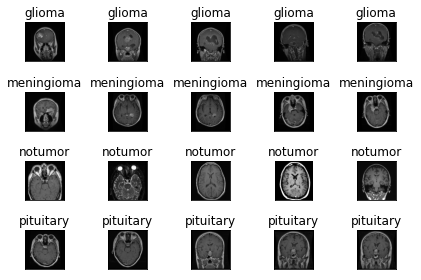

In [5]:
n_pic = 5

fig, axes = plt.subplots(len(class_labels),n_pic)

for row, label in enumerate(class_labels):
    images = os.listdir(f"{train_dir}/{label}")[:n_pic]
    for col, img in enumerate(images):
        img = f"{train_dir}/{label}/{img}"
        img = cv2.imread(img)

        axes[row][col].imshow(img)
        axes[row][col].set_xticks([])
        axes[row][col].set_yticks([])
        axes[row][col].set_title(label)
        
fig.tight_layout()

# Data Augmentation

In [6]:
train_datagen = ImageDataGenerator(
    rescale = 1/255,
    horizontal_flip = True,
    validation_split = .2)

test_datagen = ImageDataGenerator(rescale = 1/255)

In [7]:
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = "categorical",
    subset = "training",
    shuffle = True)

validation_gen = train_datagen.flow_from_directory(
    train_dir, 
    target_size = img_size,
    batch_size = batch_size,
    class_mode = "categorical",
    subset = "validation",
    shuffle = True
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = "categorical")

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


# Model Construction

In [14]:
class Performance:
  def __init__(self, train, validation, test, batch_size = 32):
    self.metrics = ['accuracy', Precision(), Recall()]
    self.batch_size = batch_size

    self.train = train
    self.validation = validation
    self.test = test

    self.columns = ["Model", "Training Accuracy", "Testing Accuracy", "Precision", "Recall", "F1-Score"]
    self.models = {col: [] for col in self.columns}
    
    self.histories = {}
    self.cm = {}

    self.trained_models = {}

  def f1_score(self, precision, recall):
    return 2 * precision * recall / (precision + recall)

  def add_record(self, model_name, history, y_pred, train_acc, test_acc, precision, recall, f1_score, verbose = True):
    self.histories[model_name] = history
    self.cm[model_name] = confusion_matrix(self.test.classes, y_pred)

    self.models["Model"].append(model_name)
    
    self.models["Training Accuracy"].append(train_acc)
    self.models["Testing Accuracy"].append(test_acc)

    self.models["Precision"].append(precision)
    self.models["Recall"].append(recall)
    
    self.models["F1-Score"].append(f1_score)

    if verbose: 
      print()
      print(f"Training Accuracy: {train_acc:.3f}")
      print(f"Testing Accuracy: {test_acc:.3f}")
      print(f"Precision: {precision: .3f}")
      print(f"Recall: {recall:.3f}")
      print(f"F1-Score: {f1_score: .3f}")

  def fit_score(self, model_name, model, test = None, verbose = True, epochs = 20):
    model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = self.metrics)

    print("Training Phase")

    history = model.fit(
        self.train, 
        epochs = epochs, 
        callbacks = [EarlyStopping(patience = 3)],
        validation_data = self.validation,
        steps_per_epoch = self.train.samples // self.batch_size, 
        validation_steps = self.validation.samples // self.batch_size
    )

    self.trained_models[model_name] = model

    f1_history = [np.asarray(val) for key, val in history.history.items() if "precision" in key] + [np.asarray(val) for key, val in history.history.items() if "recall" in key]
    history.history["f1"] = self.f1_score(f1_history[0], f1_history[2])
    history.history["val_f1"] = self.f1_score(f1_history[1], f1_history[3])

    if test is not None: self.test = test

    print("\nEvaluation Phase")
    _, train_acc, _, _ = model.evaluate(self.train)
    _, test_acc, precision, recall = model.evaluate(self.test)
    print(test_acc)
    y_pred = model.predict(self.test)
    y_pred = np.argmax(y_pred, axis=1)

    f1_score = self.f1_score(precision, recall)

    self.add_record(model_name, history, y_pred, train_acc, test_acc, precision, recall, f1_score, verbose = verbose)
  
  def plot_conf(self, n_row = 2, n_col = 2, figsize = (10,10), labels = ["Glioma", "Meningioma", "No Tumor", "Pituitary"]):
      fig, axes = plt.subplots(n_row, n_col, figsize = figsize)

      for ax, model_name in zip(axes.flatten(), self.cm):
        ConfusionMatrixDisplay(confusion_matrix = self.cm[model_name], display_labels = labels).plot(ax = ax, cmap = "Blues")
        ax.set_title(model_name)
        ax.set_xticklabels(labels, rotation = 90)

      fig.tight_layout()

  def plot_history(self, n_row = 2, n_col = 2, figsize = (10, 8), y = "loss"):
    fig, axes = plt.subplots(n_row, n_col, figsize = figsize)

    for ax, model_name in zip(axes.flatten(), self.histories):
      history = self.histories[model_name].history

      for key in history:
        if y in key:
          ax.plot(history[key])

      ax.set_title(model_name)
      ax.set_ylabel(y.title())
      ax.set_xlabel("Epoch")
      ax.legend(["Training", "Validation"], loc = 'upper left')
    
    fig.tight_layout()

metric = Performance(train_gen, validation_gen, test_gen)

## CNN

In [11]:
cnn = Sequential([
    Conv2D(32, 3, activation = "relu", input_shape = (img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D((2,2)), 
    Conv2D(16, 3, activation = "relu"), 
    BatchNormalization(),
    MaxPooling2D((2,2)), 
    Conv2D(8, 3, activation = "relu"), 
    BatchNormalization(),
    MaxPooling2D((2,2)), 
    Flatten(),
    Dense(4, activation = "softmax")
])

In [9]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 16)        4624      
                                                                 
 batch_normalization_1 (Batc  (None, 72, 72, 16)       64        
 hNormalization)                                                 
                                                        

In [10]:
metric.fit_score("CNN", cnn)

Training Phase
Epoch 1/20
142/142 [==============================] - 128s 896ms/step - loss: 0.5988 - accuracy: 0.7797 - precision: 0.8049 - recall: 0.7524 - val_loss: 2.1797 - val_accuracy: 0.3616 - val_precision: 0.3689 - val_recall: 0.3429
Epoch 2/20
142/142 [==============================] - 92s 651ms/step - loss: 0.3502 - accuracy: 0.8727 - precision: 0.8861 - recall: 0.8588 - val_loss: 1.7504 - val_accuracy: 0.5402 - val_precision: 0.5630 - val_recall: 0.5223
Epoch 3/20
142/142 [==============================] - 91s 642ms/step - loss: 0.2726 - accuracy: 0.9013 - precision: 0.9091 - recall: 0.8883 - val_loss: 0.7437 - val_accuracy: 0.7000 - val_precision: 0.7221 - val_recall: 0.6705
Epoch 4/20
142/142 [==============================] - 91s 641ms/step - loss: 0.2220 - accuracy: 0.9194 - precision: 0.9261 - recall: 0.9136 - val_loss: 0.9827 - val_accuracy: 0.7027 - val_precision: 0.7105 - val_recall: 0.6902
Epoch 5/20
142/142 [==============================] - 93s 655ms/step - loss:

## VGG-19

In [11]:
vgg_base = VGG19(include_top = False, weights = "imagenet", input_shape = (img_width, img_height, 3))
vgg_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [12]:
layers_fineTune = [f"block4_conv{i}" for i in range(1, 5)]
for layer in vgg_base.layers:

    if layer.name in layers_fineTune:
      layer.trainable = True
    else:
      layer.trainable = False

vgg = Sequential([
    vgg_base,
    Flatten(),
    Dense(4, activation = "softmax")
])

vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 32772     
                                                                 
Total params: 20,057,156
Trainable params: 8,292,356
Non-trainable params: 11,764,800
_________________________________________________________________


In [13]:
metric.fit_score("VGG19", vgg)

Training Phase
Epoch 1/20
142/142 [==============================] - 1077s 8s/step - loss: 0.9289 - accuracy: 0.6008 - precision: 0.7967 - recall: 0.5501 - val_loss: 0.9385 - val_accuracy: 0.6705 - val_precision: 0.7086 - val_recall: 0.6232
Epoch 2/20
142/142 [==============================] - 1223s 9s/step - loss: 0.4820 - accuracy: 0.8119 - precision: 0.8415 - recall: 0.7812 - val_loss: 0.7727 - val_accuracy: 0.7241 - val_precision: 0.7536 - val_recall: 0.6938
Epoch 3/20
142/142 [==============================] - 1205s 8s/step - loss: 0.3744 - accuracy: 0.8579 - precision: 0.8758 - recall: 0.8407 - val_loss: 0.7126 - val_accuracy: 0.7295 - val_precision: 0.7495 - val_recall: 0.7161
Epoch 4/20
142/142 [==============================] - 1192s 8s/step - loss: 0.3280 - accuracy: 0.8852 - precision: 0.8963 - recall: 0.8680 - val_loss: 0.7108 - val_accuracy: 0.7402 - val_precision: 0.7612 - val_recall: 0.7286
Epoch 5/20
142/142 [==============================] - 1185s 8s/step - loss: 0.309

## ResNet50

In [14]:
resNet50_base = ResNet50(include_top = False, weights = "imagenet", input_shape = (img_width, img_height, 3))
resNet50_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']      

In [15]:
layers_fineTune = [f"conv5_block3_{i}_conv" for i in range(1, 4)]
for layer in resNet50_base.layers:

    if layer.name in layers_fineTune:
      layer.trainable = True
    else:
      layer.trainable = False

resNet50 = Sequential([
    resNet50_base,
    Flatten(),
    Dense(4, activation = "softmax")
])

resNet50.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_2 (Dense)             (None, 4)                 204804    
                                                                 
Total params: 23,792,516
Trainable params: 4,664,324
Non-trainable params: 19,128,192
_________________________________________________________________


In [16]:
metric.fit_score("ResNet50", resNet50)

Training Phase
Epoch 1/20
142/142 [==============================] - 317s 2s/step - loss: 0.9638 - accuracy: 0.5918 - precision: 0.7739 - recall: 0.5272 - val_loss: 0.9748 - val_accuracy: 0.6259 - val_precision: 0.7012 - val_recall: 0.5259
Epoch 2/20
142/142 [==============================] - 306s 2s/step - loss: 0.6564 - accuracy: 0.7398 - precision: 0.7930 - recall: 0.6693 - val_loss: 0.8615 - val_accuracy: 0.7143 - val_precision: 0.7578 - val_recall: 0.6482
Epoch 3/20
142/142 [==============================] - 306s 2s/step - loss: 0.5504 - accuracy: 0.7768 - precision: 0.8078 - recall: 0.7325 - val_loss: 0.8948 - val_accuracy: 0.7161 - val_precision: 0.7380 - val_recall: 0.6714
Epoch 4/20
142/142 [==============================] - 312s 2s/step - loss: 0.5131 - accuracy: 0.7878 - precision: 0.8131 - recall: 0.7506 - val_loss: 0.7557 - val_accuracy: 0.7268 - val_precision: 0.7595 - val_recall: 0.6991
Epoch 5/20
142/142 [==============================] - 308s 2s/step - loss: 0.4609 - a

## InceptionV3

In [17]:
inc_base = InceptionV3(include_top = False, weights = "imagenet", input_shape = (img_width, img_height, 3))
inc_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 74, 74, 32)  96          ['conv2d_3[0][0]']               
 rmalization)                                                                                     
                                                                                       

In [18]:
layers_fineTune = ["conv2d_287"]

for layer in inc_base.layers:

    if layer.name in layers_fineTune:
      layer.trainable = True
    else:
      layer.trainable = False

inceptionV3 = Sequential([
    inc_base,
    Flatten(),
    Dense(4, activation = "softmax")
])

inceptionV3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten_3 (Flatten)         (None, 18432)             0         
                                                                 
 dense_3 (Dense)             (None, 4)                 73732     
                                                                 
Total params: 21,876,516
Trainable params: 73,732
Non-trainable params: 21,802,784
_________________________________________________________________


In [19]:
metric.fit_score("InceptionV3", inceptionV3)

Training Phase
Epoch 1/20
142/142 [==============================] - 138s 938ms/step - loss: 1.2192 - accuracy: 0.8035 - precision: 0.8026 - recall: 0.7928 - val_loss: 1.3173 - val_accuracy: 0.7554 - val_precision: 0.7634 - val_recall: 0.7518
Epoch 2/20
142/142 [==============================] - 131s 924ms/step - loss: 0.5898 - accuracy: 0.8854 - precision: 0.8871 - recall: 0.8848 - val_loss: 1.2529 - val_accuracy: 0.7777 - val_precision: 0.7808 - val_recall: 0.7759
Epoch 3/20
142/142 [==============================] - 131s 926ms/step - loss: 0.4217 - accuracy: 0.9130 - precision: 0.9143 - recall: 0.9125 - val_loss: 1.3389 - val_accuracy: 0.7973 - val_precision: 0.7986 - val_recall: 0.7964
Epoch 4/20
142/142 [==============================] - 123s 867ms/step - loss: 0.2544 - accuracy: 0.9401 - precision: 0.9413 - recall: 0.9392 - val_loss: 1.0430 - val_accuracy: 0.8482 - val_precision: 0.8496 - val_recall: 0.8473
Epoch 5/20
142/142 [==============================] - 121s 856ms/step - l

# Evaluation

In [20]:
pd.DataFrame(metric.models)

,Model,Training Accuracy,Testing Accuracy,Precision,Recall,F1-Score
0,CNN,0.968278,0.887109,0.893519,0.883295,0.888377
1,VGG19,0.936338,0.853547,0.861669,0.850496,0.856046
2,ResNet50,0.849048,0.777269,0.785827,0.761251,0.773344
3,InceptionV3,0.943557,0.866514,0.866310,0.864989,0.865649


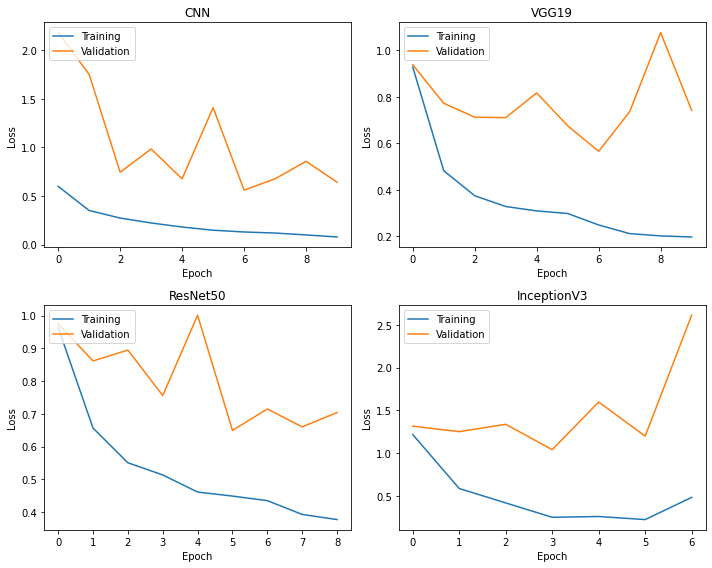

In [30]:
metric.plot_history()

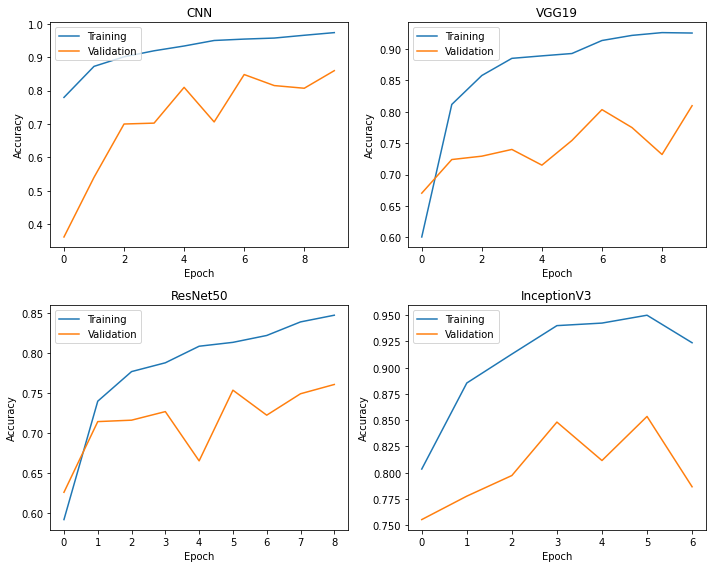

In [23]:
metric.plot_history(y = "accuracy")

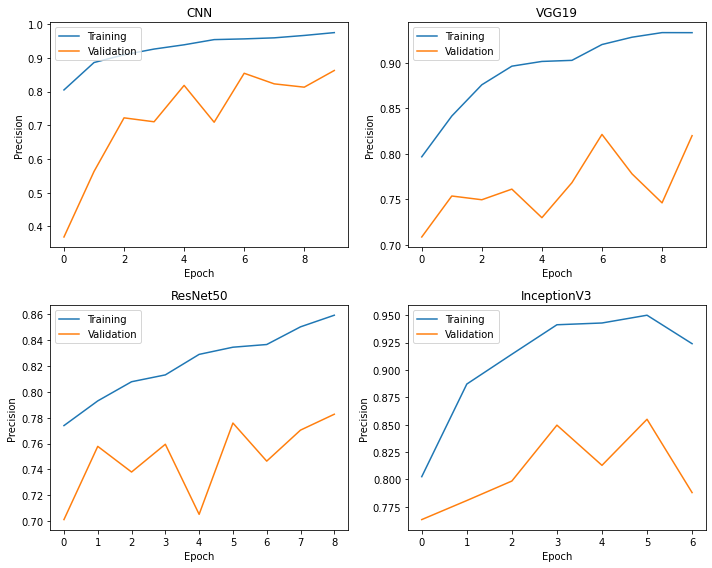

In [24]:
metric.plot_history(y = "precision")

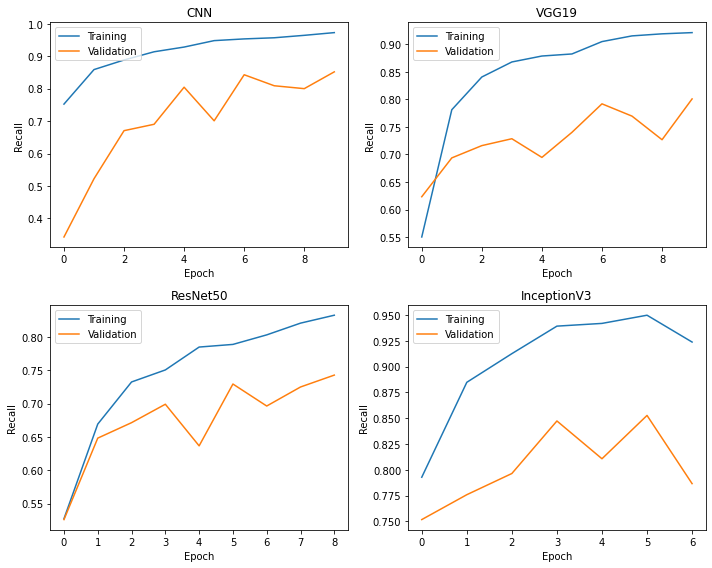

In [25]:
metric.plot_history(y = "recall")

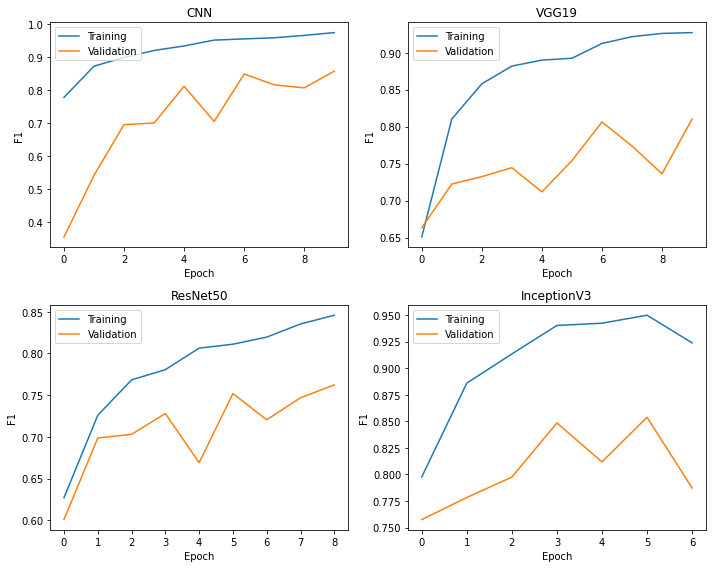

In [26]:
metric.plot_history(y = "f1")

# Prediction

CNN
1/1 [==============================] - 0s 31ms/step
VGG19
1/1 [==============================] - 0s 150ms/step
ResNet50
1/1 [==============================] - 0s 99ms/step
InceptionV3
1/1 [==============================] - 0s 56ms/step


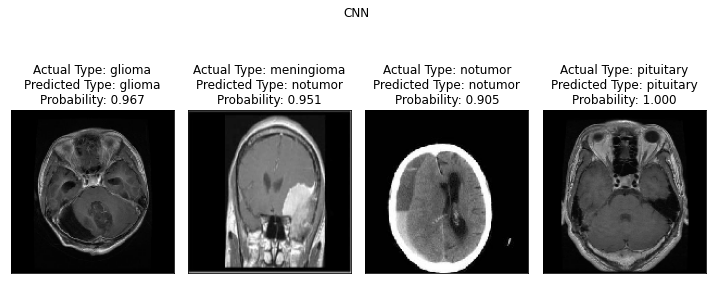

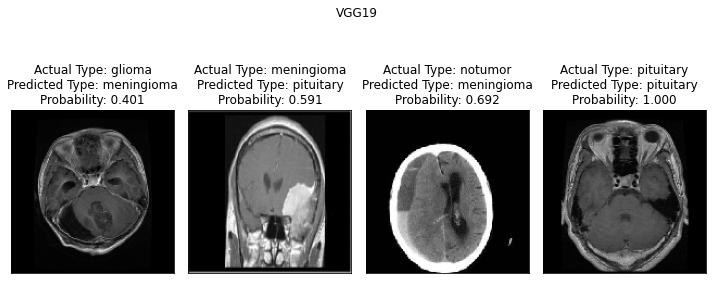

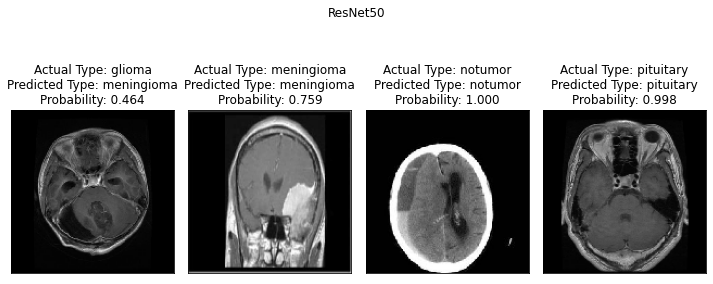

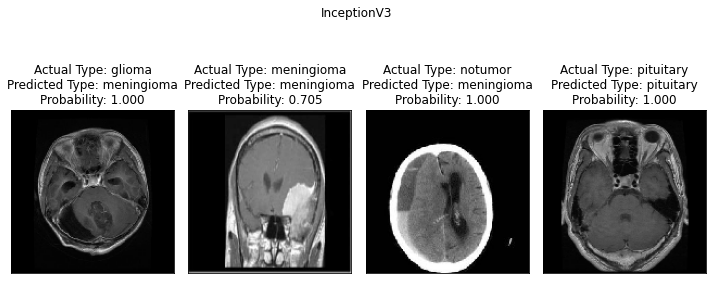

In [27]:
dict_classes = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

for model_name, model in metric.trained_models.items():
  print(model_name)

  fig, axes = plt.subplots(1, len(class_labels), figsize = (10,5))
  fig.suptitle(model_name)

  for ax, tumor_type in zip(axes.flatten(), class_labels):
    tumor_test_img = os.path.join(test_dir, tumor_type)
    tumor_test_img = os.path.join(tumor_test_img, os.listdir(tumor_test_img)[0])

    tumor_test_img = image.load_img(tumor_test_img, target_size = (img_width, img_height))

    ax.imshow(tumor_test_img)

    tumor_test_img = np.asarray(tumor_test_img) / 255
    tumor_test_img = tf.reshape(tumor_test_img, shape = [1, img_width, img_height, 3])

    pred_prob = np.max(model.predict(tumor_test_img))
   
    pred = np.argmax(model.predict(tumor_test_img))

    pred = dict_classes[pred]

    
    ax.set_title(f"Actual Type: {tumor_type}\nPredicted Type: {pred}\nProbability: {pred_prob:.3f}")
    ax.set_xticks([])
    ax.set_yticks([])
  
  fig.tight_layout()